# Assignment 1: Crack Detection in Concrete Inspection Images

In [1]:
from pathlib import Path
import os
import cv2
import numpy as np
import shutil

In [59]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else: 
    device = torch.device("cpu")
print("Device", device)

Device cuda


In [63]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split

data_dir = '../../../Downloads/concrete/train'
image_width = 64
image_height = 64
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)
])
dataset = datasets.ImageFolder(data_dir, transform=transform)

dataset_size = len(dataset)
train_size = int(0.8*dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

In [64]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)

torch.Size([32, 4096])
torch.Size([32])
torch.Size([32, 4096])
torch.Size([32])
torch.Size([32, 4096])
torch.Size([32])
torch.Size([32, 4096])
torch.Size([32])
torch.Size([32, 4096])
torch.Size([32])
torch.Size([32, 4096])
torch.Size([32])
torch.Size([32, 4096])
torch.Size([32])
torch.Size([32, 4096])
torch.Size([32])
torch.Size([32, 4096])
torch.Size([32])
torch.Size([32, 4096])
torch.Size([32])
torch.Size([32, 4096])
torch.Size([32])
torch.Size([32, 4096])
torch.Size([32])
torch.Size([9, 4096])
torch.Size([9])


In [52]:
dataset.classes

['crack', 'normal']

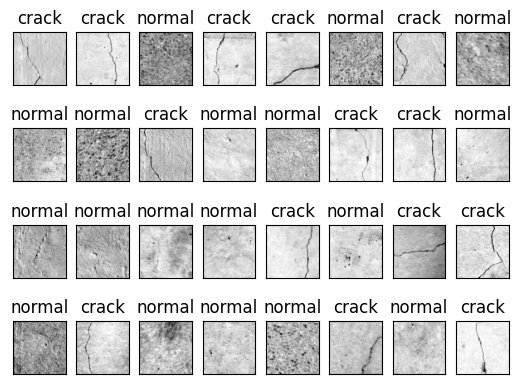

In [65]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))
plt.figure()
for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,8,i+1)
    plt.imshow(image.reshape(image_height,image_width),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(dataset.classes[label])

In [66]:
import torch.nn as nn
import torch.nn.functional as F

In [67]:
loss_module = nn.BCEWithLogitsLoss()

In [68]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [77]:
model = SimpleClassifier(num_inputs=image_height*image_width, num_hidden=4096, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=4096, out_features=4096, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4096, out_features=1, bias=True)
)


In [84]:
# Input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [79]:
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=4096, out_features=4096, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4096, out_features=1, bias=True)
)

In [88]:
from tqdm import tqdm

def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

In [95]:
train_model(model, optimizer, train_loader, loss_module, num_epochs=1000)

 92%|█████████▏| 915/1000 [05:51<00:32,  2.60it/s]


KeyboardInterrupt: 

In [96]:
def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [97]:
eval_model(model, train_loader)

Accuracy of the model: 57.25%


In [98]:
eval_model(model, val_loader)

Accuracy of the model: 57.58%


In [100]:
data_dir

'../../../Downloads/concrete/train'